<a href="https://colab.research.google.com/github/mendezfranco/Repositorio-FMendez-SOA/blob/master/Mendez_Franco_Ejercicio_2_Paralelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Introducción**

El siguiente ejercicio tiene como objetivo desarrollar en el lenguaje de programación Python y valiéndose de la API de desarrollo GPGPU CUDA para Python (*pycuda*), el algoritmo necesario para elevar una matriz de NxN al cuadrado.

La potencia de matrices se lleva a cabo mediante el proceso de multiplicación de la matriz por sí misma. Matemáticamente, podemos definir al producto entre matrices de la siguiente manera:

Siendo las matrices

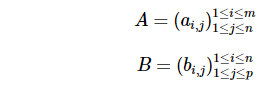

entonces, el producto de *A.B* es

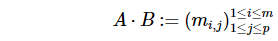

siendo 

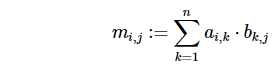

Para clarificar la definición matemática, podemos ejemplificar de la siguiente manera:

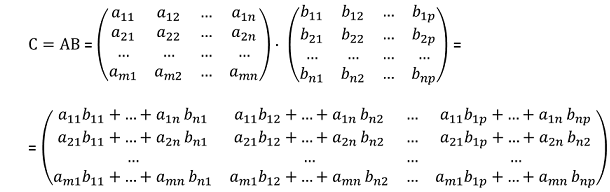


El ejercicio toma como parámetro de entrada la cantidad de filas / columnas de la matriz cuadrada, es decir, el valor de N. Seguidamente, crea una matriz con valores de tipo decimales aleatoriamente, para luego efectuar el cuadrado de la misma, procesando en paralelo a través del entorno GPU.

---

**2. Armado del Ambiente**

Previo a la ejecución del algoritmo, se debe instalar en Colab el módulo CUDA para python: pycuda. Pycuda es una librería que permite obtener acceso a la API de computación y procesamiento en paralelo CUDA de Nvidia para desarrolladores de python. 

In [1]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 14.2MB/s 
     |████████████████████████████████| 71kB 9.6MB/s 
     |████████████████████████████████| 81kB 12.3MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621008 sha256=2e99c5256d043870364fca746854bef9278de7e0fc01b45f5d23cb1d505c6501
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=14107aba56cd64d1b4d81635db3bb38a26748038526f2870e92ccba0b8339c33
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools




---



**3. Desarrollo**

A continuación se codifican las funcionalidades para cumplir con el objetivo del ejercicio.

In [4]:
#@title Parámetros Iniciales { vertical-output: true }

tamanio_matriz = 50#@param {type: "number"}

# Importo las bibliotecas necesarias
from datetime import datetime

tiempo_total = datetime.now()

import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# Creo una función para transformar el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

# CPU - Defino la memoria de las matrices en cpu.
matriz_cpu = np.random.uniform(low=-50.0, high=50.0, size=(tamanio_matriz,tamanio_matriz))#.random((tamanio_matriz,tamanio_matriz))
matriz_cpu = matriz_cpu.astype(np.float32())

matriz_resultante_cpu = np.zeros_like(matriz_cpu)
matriz_resultante_cpu = matriz_cpu.astype(np.float32())

# CPU - reservo la memoria GPU.
matriz_gpu = cuda.mem_alloc(matriz_cpu.nbytes)
matriz_resultante_gpu = cuda.mem_alloc(matriz_resultante_cpu.nbytes)

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod(matriz_gpu, matriz_cpu)
cuda.memcpy_htod(matriz_resultante_gpu, matriz_resultante_cpu)

#CPU - Defino la funcion kernel que ejecutará en GPU
module = SourceModule("""
__global__ void kernel_potencia(int n, float *matriz, float *matriz_res)
{
    int i;
    int idx = threadIdx.x + blockIdx.x*blockDim.x; 
    int idy = threadIdx.y + blockIdx.y*blockDim.y; 

    if (idx < n && idy < n) {
      float suma=0;
      for (i = 0; i < n; i++) {
        suma += (matriz[idy * n + i] * matriz[i * n + idx]);
      }
      matriz_res[idy * n + idx] = suma;
    }
}
""")

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_potencia")

# CPU - Definición de dimensiones
dim_hilo_x = 16
dim_bloque_x = np.int( (tamanio_matriz+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 16
dim_bloque_y = np.int( (tamanio_matriz+dim_hilo_y-1) / dim_hilo_y )

tiempo_gpu = datetime.now()

# GPU - Ejecuta el kernel.
kernel( np.int32(tamanio_matriz), matriz_gpu, matriz_resultante_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ),grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_gpu = datetime.now() - tiempo_gpu

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh(matriz_resultante_cpu, matriz_resultante_gpu)

# CPU - Defino la cantidad de decimales que se van a mostrar para cada valor
# para el caso en que se quieran imprimir los resultados
np.set_printoptions(precision=3)

tiempo_total = datetime.now() - tiempo_total

# Imprimo los resultados y tiempos totales
print("Matriz original: ")
print(matriz_cpu)
print("")

print("Matriz al Cuadrado: ")
print(matriz_resultante_cpu)
print("")

print("Tiempos Totales: ")
print("Tiempo GPU: ", tiempo_en_ms(tiempo_gpu))
print("Tiempo Total: ", tiempo_en_ms(tiempo_total))



Matriz original: 
[[-10.256  22.155 -39.095 ...  41.465   1.957 -25.808]
 [-30.582 -18.29   19.871 ...  38.169  49.924  44.908]
 [ 32.807 -14.431  40.698 ...   3.913  49.159  14.379]
 ...
 [ 34.108  31.593  23.755 ... -43.939 -22.626 -29.532]
 [ 12.477  30.936  47.731 ...  15.631 -12.911 -14.548]
 [  9.043  20.842  36.704 ...  34.392 -34.688  33.66 ]]

Matriz al Cuadrado: 
[[ 6229.907  1119.013  4552.469 ... -5815.923 -1586.69  -5664.932]
 [ 6652.352  8058.836  5115.598 ... -6239.155 -3426.523 -4990.635]
 [ 1514.165  7780.224  4540.884 ... 21000.4    5093.549 -4965.782]
 ...
 [-8933.391    93.856 -9631.234 ... -6843.322  3889.696 11233.812]
 [-3629.684 -8910.252   101.752 ... -9364.819  6965.299  2500.977]
 [-1148.263  1757.158 -3931.155 ... -7930.298 -3013.439 14379.929]]

Tiempos Totales: 
Tiempo GPU:  0.112
Tiempo Total:  1.701


**4. Tabla de Pasos**

Resumen de las funciones principales del desarrollo

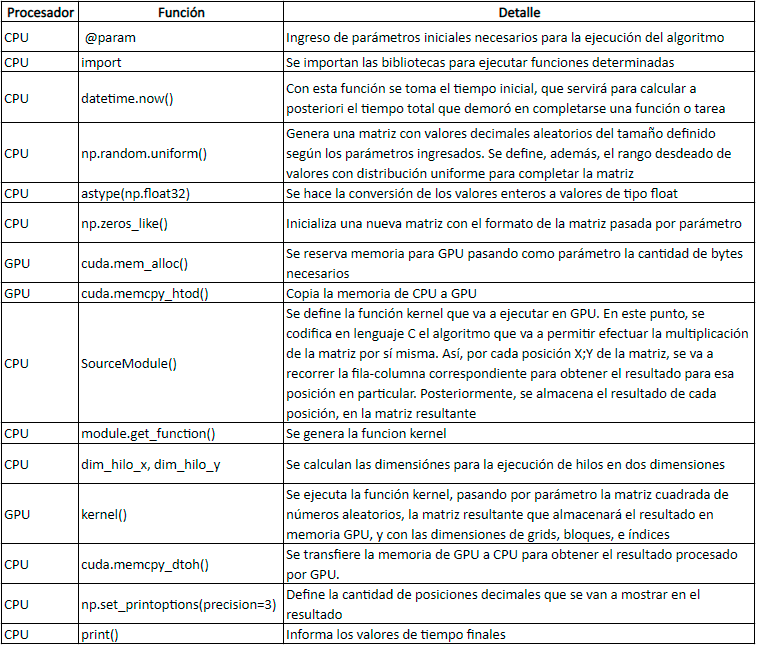

---

**5. Conclusiones**

*Repaso*

El procesamiento de datos en paralelo mediante GPU brinda una gran diferencia en términos de performance y velocidad, respecto de la misma solución de forma secuencial. Aprovechando las ventajas del potencial de la GPU y sus hilos en dos dimensiones para ejecutar grandes lotes de procesamiento, como puede ser la potencia de matrices cuadradas de gran cantidad de filas-columnas, podemos obtener una solución cuyos tiempos totales sean menores. En este ejercicio, se utilizan threads en 2D, lo cual permite asociar a cada hilo con una posición específica de la matriz, para que cada uno de ellos ejecuten independientemente las operaciones del producto matricial.
Comparando directamente contra la solución secuencial del algoritmo, vemos plasmada la enorme diferencia en materia de tiempos, algunos ejemplos mostrados a continuación:

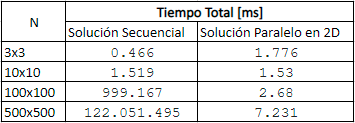

Para matrices más pequeñas, la solución secuencial brinda un mejor tiempo total debido a que no se efectúan las operciones de reserva y manejo de memoria entre CPU y GPU, sin embargo, a medida que aumentamos la cantidad de valores de la matriz, los tiempos totales son cada vez más dispares, evidenciando la necesidad de las soluciones paralelas en problemas que requieran procesamiento de grandes volúmenes de datos.


*Lecciones Aprendidas*

En el desarrollo de este ejercicio de procesamiento paralelo con GPU, pude adquirir conocimiento acerca de cómo trabajar con hilos de GPU en dos dimensiones: formas de obtener el acceso a dichos hilos, y su uso en el cálculo y operaciones específicas. También me permitió comprender de qué forma se pueden adoptar soluciones de procesamiento paralelo en la operación de matrices, así como también pude ahondar en los conocimientos adquiridos en ejercicios anteriores sobre CUDA, grillas y bloques.

*Sugerencias para continuar con el ejercicio, mejoras*

Como mejora al ejercicio presentado, se podría adoptar una solución que permita al usuario ingresar como parámetro un conjunto de valores para completar la matriz. Adicionalmente, se podría implementar una solución que permita multiplicar dos matrices diferentes, validando previamente las dimensiones de ambas matrices para comprobar si es posible efectuar esa multiplicación (ya que para poder realizar el producto entre dos matrices, el número de filas de la matriz A, debe coincidir con el número de columnas de la matriz B).

---

**6. Bibliografía**

[1] Matrices: Conceptos básicos: [WEB](https://aga.frba.utn.edu.ar/matrices/)

[2] Python Matrices and NumPy Arrays: [WEB](https://www.programiz.com/python-programming/matrix)

[3] CUDA Thread Indexing: [WEB](https://blog.usejournal.com/cuda-thread-indexing-fb9910cba084)

[4] Numpy random: [WEB](https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html)

[5] Introducción a las matrices en Python: [PDF](https://www.cartagena99.com/recursos/alumnos/apuntes/introduccion%20matrices.pdf)

[6] 1D, 2D and 3D thread allocation for loops in CUDA: [WEB](https://medium.com/@erangadulshan.14/1d-2d-and-3d-thread-allocation-for-loops-in-cuda-e0f908537a52)

[7] CUDA for Engineers: 2D Grids and Interactive Graphics: [WEB](https://www.informit.com/articles/article.aspx?p=2455391)